Epoch 1/100


c:\Users\Alma\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4838/4838 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1015.1295
Epoch 2/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0532
Epoch 3/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0670
Epoch 4/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1785
Epoch 5/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1867
Epoch 6/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0817
Epoch 7/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1317
Epoch 8/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2200
Epoch 9/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0821
Epoch 10/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1079
Epoch 11/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0848
Epoch 12/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0554
Epoch 13/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2018
Epoch 14/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0904
Epoch 15/100
4838/4838

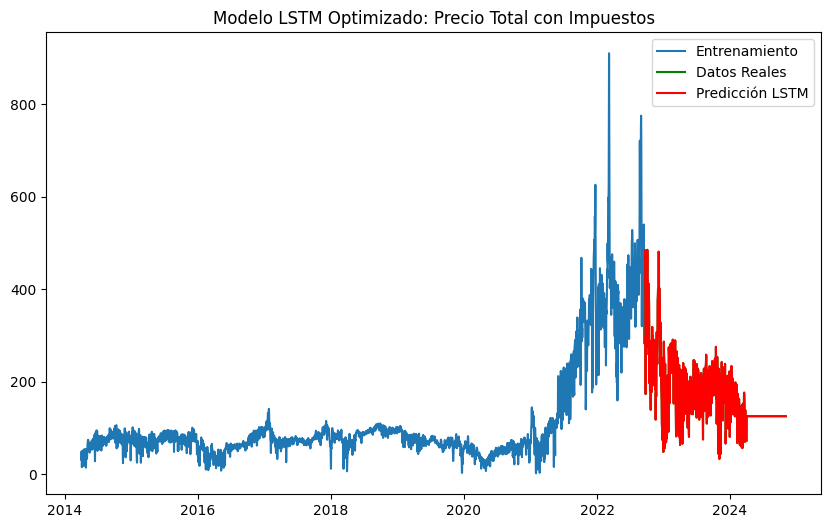

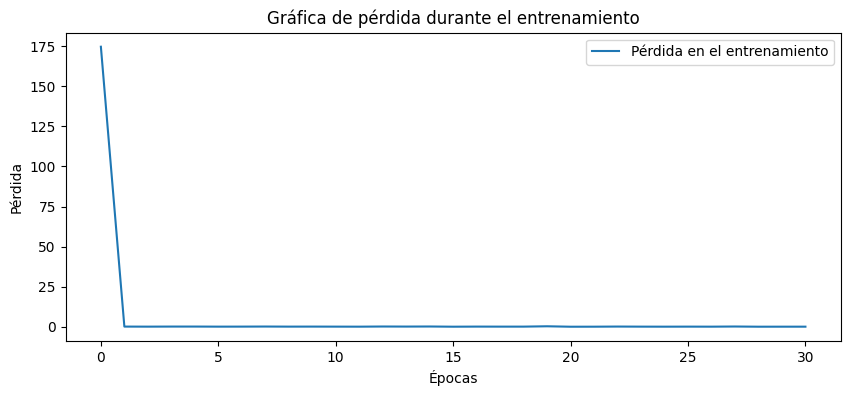

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# *1. Cargar el dataset*
file_path = "../Limpieza_datos/Modelo_Precios_Met_Fest.csv"  
data = pd.read_csv(file_path, delimiter=';')

# *2. Preprocesamiento del dataset*
data['FECHA'] = pd.to_datetime(data['FECHA'])
data = data.sort_values(by='FECHA')

# *Filtrar la serie temporal de interés (Precio total con impuestos (€/MWh))*
serie_temporal = data.set_index('FECHA')['Precio total con impuestos (€/MWh)'].dropna()

# *3. División de los datos en entrenamiento y prueba (80% - 20%)*
train_size = int(len(serie_temporal) * 0.8)
train, test = serie_temporal.iloc[:train_size], serie_temporal.iloc[train_size:]

# *Preparación de los datos para LSTM*
X_train_nn = np.array(train).reshape(-1, 1, 1)  # Formato (samples, timesteps, features)
X_test_nn = np.array(test).reshape(-1, 1, 1)

# *4. Definición del modelo LSTM optimizado*
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(1, 1), return_sequences=True),  # Más neuronas y return_sequences
    tf.keras.layers.LSTM(50, activation='relu'),  # Segunda capa LSTM
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# *Callback para Early Stopping*
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# *5. Entrenamiento del modelo*
history = model_lstm.fit(X_train_nn, train.values, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

# *6. Predicciones*
predictions_lstm = model_lstm.predict(X_test_nn).flatten()

# *7. Evaluación del modelo*
rmse_lstm = np.sqrt(mean_squared_error(test, predictions_lstm))
r2_lstm = r2_score(test, predictions_lstm)

print(f"RMSE del Modelo LSTM Optimizado: {rmse_lstm:.2f}")
print(f"R² del Modelo LSTM Optimizado: {r2_lstm:.2f}")

# *8. Visualización de los resultados*
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label='Entrenamiento')
plt.plot(test.index, test.values, label='Datos Reales', color='green')
plt.plot(test.index, predictions_lstm, label='Predicción LSTM', color='red')
plt.legend()
plt.title('Modelo LSTM Optimizado: Precio Total con Impuestos')
plt.show()

# *9. Visualización de la pérdida*
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Pérdida en el entrenamiento')
plt.title('Gráfica de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

RMSE: 5.91
R²: 0.99


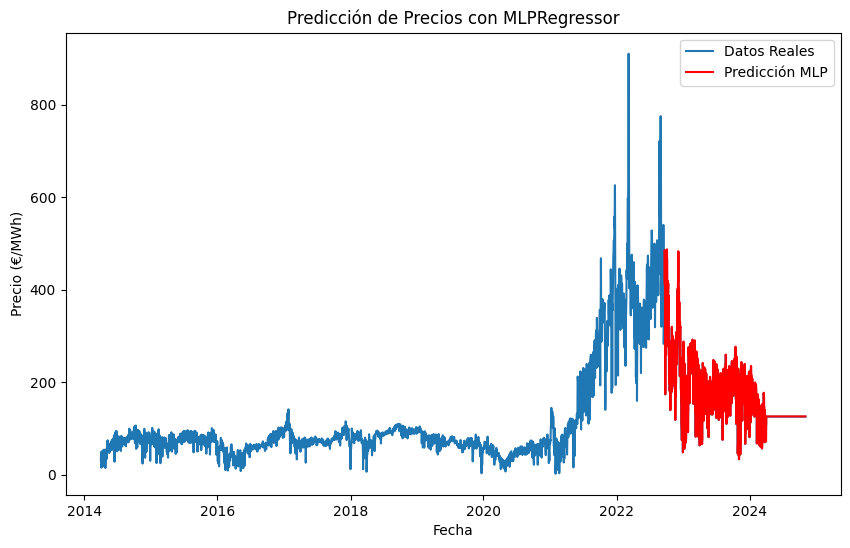

Modelo guardado en formato .pkl exitosamente.


In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle

# 1. Cargar el dataset
file_path = "../Limpieza_datos/Modelo_Precios_Met_Fest.csv"
data = pd.read_csv(file_path, delimiter=';')

# 2. Preprocesamiento del dataset
data['FECHA'] = pd.to_datetime(data['FECHA'])
data = data.sort_values(by='FECHA')

# Usaremos la columna "Precio total con impuestos (€/MWh)" como serie temporal
serie_temporal = data.set_index('FECHA')['Precio total con impuestos (€/MWh)'].dropna()

# 3. Construir el dataset para predicción
# Usaremos la técnica de ventanas de tamaño 1:
#   X[i] = precio en t, y[i] = precio en t+1
prices = serie_temporal.values
X = prices[:-1].reshape(-1, 1)  # características: precio actual
y = prices[1:]                  # etiquetas: precio siguiente

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Definir y entrenar el modelo usando MLPRegressor de scikit-learn
model = MLPRegressor(hidden_layer_sizes=(100, 50), 
                     activation='relu', 
                     solver='adam', 
                     max_iter=500, 
                     random_state=42)

model.fit(X_train, y_train)

# 5. Realizar predicciones
predictions = model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# 6. Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(serie_temporal.index, serie_temporal.values, label='Datos Reales')
# Ajustamos el índice para las predicciones. Notar que hay una diferencia de 1 punto.
plt.plot(serie_temporal.index[train_size+1:], predictions, label='Predicción MLP', color='red')
plt.legend()
plt.title('Predicción de Precios con MLPRegressor')
plt.xlabel('Fecha')
plt.ylabel('Precio (€/MWh)')
plt.show()

# 7. Guardar el modelo en formato .pkl
modelo_pkl_path = "../modelos_guardados/AModelo_precios_mlp.pkl"
with open(modelo_pkl_path, "wb") as f:
    pickle.dump(model, f)

print("Modelo guardado en formato .pkl exitosamente.")


In [3]:
import pickle
import numpy as np

# Cargar el modelo guardado (asegúrate de que la ruta sea correcta)
modelo_pkl_path = "../modelos_guardados/AModelo_precios_mlp.pkl"
with open(modelo_pkl_path, "rb") as f:
    model = pickle.load(f)

# Valor de entrada: Último precio conocido (por ejemplo, 100)
last_price = 100  # Asegúrate de que este valor esté en la misma escala que en el entrenamiento

# La entrada debe ser un array de forma (1, 1)
entrada = np.array([[last_price]])

# Realizar la predicción
prediccion = model.predict(entrada)[0]

print("Último precio introducido:", last_price)
print("Precio siguiente predicho:", prediccion)


Último precio introducido: 100
Precio siguiente predicho: 100.42683320232987


In [4]:
# Para predecir múltiples precios a partir de varios últimos precios conocidos:
entradas = np.array([[100], [105], [98]])  # Tres muestras, cada una con un valor
predicciones = model.predict(entradas)
print("Predicciones:", predicciones)


Predicciones: [100.4268332  105.44572034  98.41927835]


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

# 1. Cargar el modelo guardado (asegúrate de que la ruta sea correcta)
modelo_pkl_path = "../modelos_guardados/AModelo_precios_mlp.pkl"
with open(modelo_pkl_path, "rb") as f:
    model = pickle.load(f)

# 2. Cargar el dataset y obtener el último precio
file_path = "../Limpieza_datos/Modelo_Precios_Met_Fest.csv"
data = pd.read_csv(file_path, delimiter=';')
data['FECHA'] = pd.to_datetime(data['FECHA'])
data = data.sort_values(by='FECHA')

# Filtrar datos por provincia (opcional, según necesites)
provincia = "ALAVA"  # Por ejemplo
data_provincia = data[data['Provincia'].str.upper() == provincia.upper()]
if data_provincia.empty:
    raise ValueError(f"No se encontraron datos para la provincia {provincia}")

# Obtener el último precio de la columna de interés
ultimo_precio = data_provincia['Precio total con impuestos (€/MWh)'].values[-1]
print("Último precio histórico:", ultimo_precio)

# 3. Definir el rango de fechas para el que se desea predecir
# Por ejemplo, enero 2025: desde el 1 al 31 de enero
fecha_inicio = "2025-01-01"
fecha_fin = "2025-01-31"
fecha_inicio_dt = pd.to_datetime(fecha_inicio)
fecha_fin_dt = pd.to_datetime(fecha_fin)

# Generar un rango de fechas diario
rango_fechas = pd.date_range(start=fecha_inicio_dt, end=fecha_fin_dt, freq='D')
n_dias = len(rango_fechas)
print(f"Cantidad de días a predecir: {n_dias}")

# 4. Predicción recursiva: para cada día se predice el siguiente precio
predicciones = []  # para almacenar el precio predicho cada día
precio_actual = ultimo_precio  # punto de partida

for dia in rango_fechas:
    # Preparar la entrada con la forma (1, 1) ya que el modelo fue entrenado con ventanas de tamaño 1
    entrada = np.array([[precio_actual]])
    precio_siguiente = model.predict(entrada)[0]  # predicción para el siguiente día
    predicciones.append(precio_siguiente)
    # Actualizar el precio_actual con el valor predicho para la siguiente iteración
    precio_actual = precio_siguiente

# 5. Calcular el precio medio en el rango
precio_medio = np.mean(predicciones)
print(f"Precio medio predicho para el intervalo {fecha_inicio} a {fecha_fin} en {provincia}: {precio_medio:.2f} €/MWh")


Último precio histórico: 125.57008176195198
Cantidad de días a predecir: 31
Precio medio predicho para el intervalo 2025-01-01 a 2025-01-31 en ALAVA: 134.27 €/MWh


Epoch 1/100


c:\Users\Alma\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4838/4838 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1177.2281
Epoch 2/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0446
Epoch 3/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1447
Epoch 4/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1233
Epoch 5/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3080
Epoch 6/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1262
Epoch 7/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2591
Epoch 8/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0518
Epoch 9/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0454
Epoch 10/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1107
Epoch 11/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0860
Epoch 12/100
4838/4838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0233
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step
RMSE del Modelo LSTM Optimizado: 0.04
R² del Modelo LSTM Optimizado: 1.00


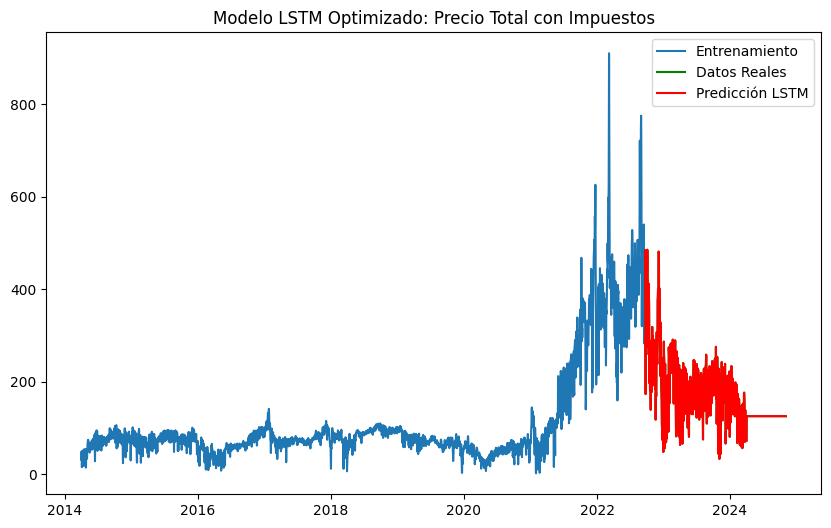

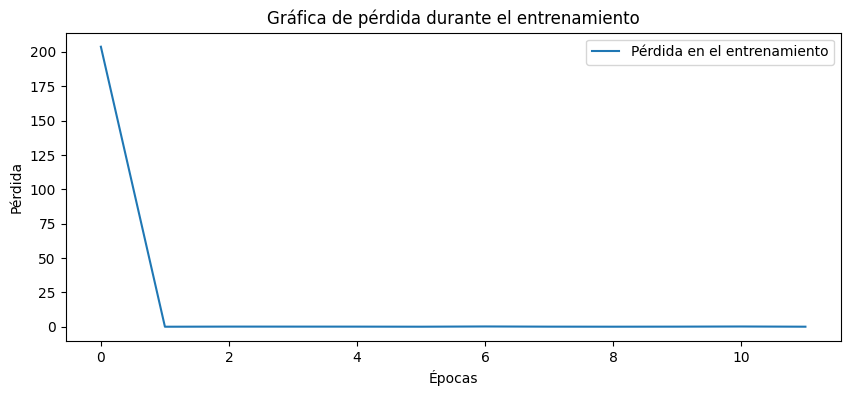

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# *1. Cargar el dataset*
file_path = "../Limpieza_datos/Modelo_Precios_Met_Fest.csv"  
data = pd.read_csv(file_path, delimiter=';')

# *2. Preprocesamiento del dataset*
data['FECHA'] = pd.to_datetime(data['FECHA'])
data = data.sort_values(by='FECHA')

# *Filtrar la serie temporal de interés (Precio total con impuestos (€/MWh))*
serie_temporal = data.set_index('FECHA')['Precio total con impuestos (€/MWh)'].dropna()

# *3. División de los datos en entrenamiento y prueba (80% - 20%)*
train_size = int(len(serie_temporal) * 0.8)
train, test = serie_temporal.iloc[:train_size], serie_temporal.iloc[train_size:]

# *Preparación de los datos para LSTM*
X_train_nn = np.array(train).reshape(-1, 1, 1)  # Formato (samples, timesteps, features)
X_test_nn = np.array(test).reshape(-1, 1, 1)

# *4. Definición del modelo LSTM optimizado*
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(1, 1), return_sequences=True),  # Más neuronas y return_sequences
    tf.keras.layers.LSTM(50, activation='relu'),  # Segunda capa LSTM
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# *Callback para Early Stopping*
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# *5. Entrenamiento del modelo*
history = model_lstm.fit(X_train_nn, train.values, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

# *6. Predicciones*
predictions_lstm = model_lstm.predict(X_test_nn).flatten()

# *7. Evaluación del modelo*
rmse_lstm = np.sqrt(mean_squared_error(test, predictions_lstm))
r2_lstm = r2_score(test, predictions_lstm)

print(f"RMSE del Modelo LSTM Optimizado: {rmse_lstm:.2f}")
print(f"R² del Modelo LSTM Optimizado: {r2_lstm:.2f}")

# *8. Visualización de los resultados*
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label='Entrenamiento')
plt.plot(test.index, test.values, label='Datos Reales', color='green')
plt.plot(test.index, predictions_lstm, label='Predicción LSTM', color='red')
plt.legend()
plt.title('Modelo LSTM Optimizado: Precio Total con Impuestos')
plt.show()

# *9. Visualización de la pérdida*
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Pérdida en el entrenamiento')
plt.title('Gráfica de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [3]:
model_lstm.save('../modelos_guardados/AModelo_precios.h5')